In [1]:
import math

%matplotlib inline
from matplotlib import pyplot as plt

import gpytorch
import torch

import pyro
from pyro.infer.mcmc import NUTS, MCMC
pyro.set_rng_seed(0)

In [2]:
train_x = torch.linspace(0, 2, 7)
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.1

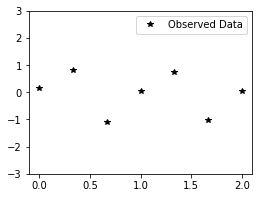

In [3]:
f, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
ax.set_ylim([-3, 3])
ax.legend(['Observed Data']);

In [4]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, batch_shape=torch.Size()):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean(
            batch_shape=batch_shape,
        )
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.PeriodicKernel(batch_shape=batch_shape),
            batch_shape=batch_shape
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [5]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood, batch_shape=torch.Size())
model.train()
likelihood.train()
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
init_params = {k: v for k, v in model.state_dict().items()}
init_params

{'likelihood.noise_covar.raw_noise': tensor([0.]),
 'mean_module.constant': tensor([0.]),
 'covar_module.raw_outputscale': tensor(0.),
 'covar_module.base_kernel.raw_lengthscale': tensor([[0.]]),
 'covar_module.base_kernel.raw_period_length': tensor([[0.]])}

In [6]:
#model.likelihood.noise_covar.register_constraint('raw_noise', gpytorch.constraints.Interval(0, 10))
#model.covar_module.register_constraint('raw_outputscale', gpytorch.constraints.Interval(0, 10))
#model.covar_module.base_kernel.register_constraint('raw_lengthscale', gpytorch.constraints.Interval(0, 10))
#model.covar_module.base_kernel.register_constraint('raw_period_length', gpytorch.constraints.Interval(0, 10))

In [7]:
def transform_jacobian(model, params):
    r = 0
    for name, param in params.items():
        constraint = model.constraint_for_parameter_name(name)
        if isinstance(constraint, gpytorch.constraints.GreaterThan):
            # derivative of softplus is sigmoid
            r = r + torch.sigmoid(param).sum()
        elif isinstance(constraint, gpytorch.constraints.Interval):
            # derivative of sigmoid and affine transform
            sigmoid = torch.sigmoid(param)
            jac = torch.log(sigmoid * (1 - sigmoid) * (constraint.upper_bound - constraint.lower_bound))
            r = r + jac.sum()
            print(jac)
    return r

In [8]:
def potential_fn(params):
    try:
        model._load_raw_parameters(**params)
        output = model(train_x)
        log_joint = mll(output, train_y).sum()
        log_joint = log_joint + transform_jacobian(model, params)
        return -log_joint
    except:  # return `nan` instead
        r = 0
        for p in params.values():
            r = r + 0 * p.sum()
        return torch.tensor(float('nan')) + r

In [9]:
hmc_kernel = NUTS(model=None, potential_fn=potential_fn, jit_compile=False,
                  ignore_jit_warnings=True)
hmc_kernel.initial_params = init_params
mcmc_run = MCMC(hmc_kernel, num_samples=100, warmup_steps=100).run()

Warmup:  22%|██▎       | 45/200 [00:52<02:44,  1.06s/it, step size=1.39e+01, acc. rate=1.000]/home/fehiepsi/gpytorch/gpytorch/utils/cholesky.py:42: RuntimeWarning: A not p.d., added jitter of 1e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter} to the diagonal", RuntimeWarning)
Sample: 100%|██████████| 200/200 [03:54<00:00,  2.83s/it, step size=9.11e-02, acc. rate=0.995]


In [10]:
def inv_transform(model, params):
    samples = {}
    for name, param in params.items():
        constraint = model.constraint_for_parameter_name(name)
        if constraint is not None:
            splitted_name = name.split('.')
            new_name = '.'.join(splitted_name[:-1]
                                + [splitted_name[-1].lstrip('raw_').rstrip('_constraint')])
            samples[new_name] = constraint.transform(param)
        else:
            samples[name] = param
    return samples

In [11]:
samples = [inv_transform(model, params) for params in mcmc_run.exec_traces]
merged_samples = {}
for name in samples[0]:
    merged_samples[name] = torch.stack([sample[name] for sample in samples])

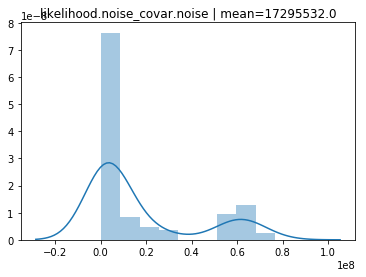

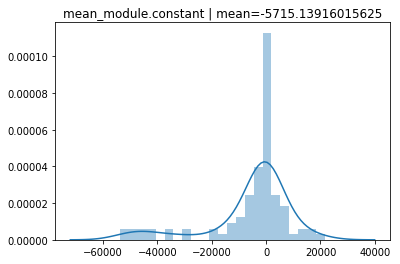

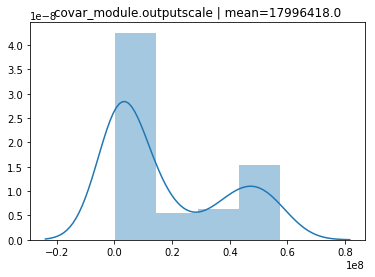

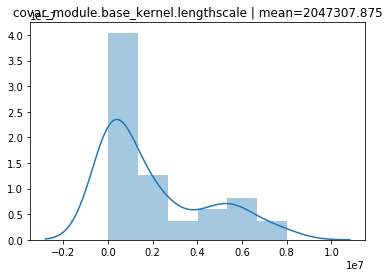

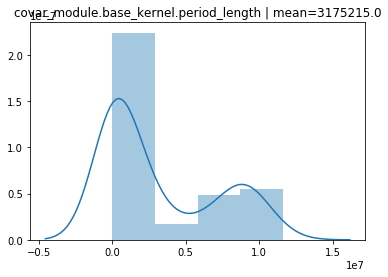

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

for name in merged_samples:
    sns.distplot(merged_samples[name])
    plt.title(name + " | mean={}".format(merged_samples[name].mean().item()))
    plt.show()